### DVAE (VRNN architecture)

Here is a first implementation of a DVAE for the MOVING MNIST dataset.

In [17]:
import scipy
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# import data from the moving mnist dataset
data = np.load('data/bouncing_mnist_test.npy')

# normalize the data to be between 0 and 1 (better training performance for some reason)
data = data / 255

In [4]:
class VRNN(nn.Module):

    '''
    the Varational Recurrent Neural Network VRNN is a dynamical VAE model.
    
    '''

    def __init__(self, img_size=64, hidden_size=256, latent_size=16, RNN_dim=256, CNN_channels=32):

        super(VRNN, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.rnn_dim = RNN_dim

        # convolutions parameters
        self.CNN_channels = CNN_channels
        self.img_size = img_size
        self.feature_size_enc = 14*14*CNN_channels # output of convolutional layers
        self.feature_size_dec = 12*12*CNN_channels # inpout of transposed convolutional layers
        self.feature_size = (img_size-8)*(img_size-8)*CNN_channels # output of convolutional layers
        
        # feature extractor of observation with convolutional layers
        self.enc_conv1 = nn.Conv2d(1, CNN_channels//2, kernel_size=5)
        self.enc_conv2 = nn.Conv2d(CNN_channels//2, CNN_channels, kernel_size=5)
        self.enc_maxpool = nn.MaxPool2d(4)

        # encoder part of the model
        self.encoder = nn.Sequential(
            nn.Linear( self.feature_size_enc + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.enc_mean = nn.Linear(hidden_size, latent_size)
        self.enc_logvar = nn.Linear(hidden_size, latent_size)

        # encoding the prior on the latent space given previous dynamics
        self.prior_encoder = nn.Sequential(
            nn.Linear(RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.prior_mean = nn.Linear(hidden_size, latent_size)
        self.prior_logvar = nn.Linear(hidden_size, latent_size)

        # feature extractor of latent states with inverse convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(CNN_channels, CNN_channels//2, kernel_size=5, stride=5)
        self.dec_conv2 = nn.ConvTranspose2d(CNN_channels//2, 1, kernel_size=5)

        # decoder part of the model, output the reconstructed observation y_t
        self.decoder = nn.Sequential(
            nn.Linear(latent_size + RNN_dim, hidden_size),
            nn.Tanh()
        )
        self.dec_mean = nn.Linear(hidden_size, self.feature_size_dec)
        # self.dec_logvar = nn.Linear(hidden_size, self.feature_size)

        # RNN part of the model, encode the dynamics of the latent space
        self.rnn = nn.RNN(self.feature_size_enc + latent_size, RNN_dim)#

        self.relu = nn.ReLU()

    def reparametrization(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + std * eps
    
    def forward(self,x,generation_mode=False,generation_ratio=0):

        seq_len, batch_size,_,_ = x.shape

        # create variable holder
        self.z_mean = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z_logvar = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z = torch.zeros(seq_len, batch_size, self.latent_size).to(device)

        h = torch.zeros((seq_len, batch_size, self.rnn_dim)).to(device)
        z_t = torch.zeros((batch_size, self.latent_size)).to(device)
        h_t = torch.zeros((batch_size, self.rnn_dim)).to(device) # the initial hidden state coudl be different from 0 ... (random ?)

        y = torch.zeros((seq_len, batch_size, self.img_size,self.img_size)).to(device) # observation reconstruction

        for t in range(seq_len):

            x_t = x[t,:,:,:].unsqueeze(1)

            # feature extractor of observation with convolutional layers
            phi_x_t = self.relu(self.enc_conv1(x_t))
            phi_x_t = self.enc_conv2(phi_x_t)
            phi_x_t = self.enc_maxpool(phi_x_t)
            phi_x_t = self.relu(phi_x_t)
            phi_x_t = phi_x_t.view(-1, self.feature_size_enc )
            encoder_input = torch.cat((phi_x_t,h_t),dim=1)
            encoder_output = self.encoder(encoder_input)
            mean_zt, logvar_zt = self.enc_mean(encoder_output), self.enc_logvar(encoder_output)

            # sample the latent variable
            if generation_mode and t > 0 :
                prior_encoder_t = self.prior_encoder(h_t)
                prior_mean_zt = self.prior_mean(prior_encoder_t)
                prior_logvar_zt = self.prior_logvar(prior_encoder_t)
                z_t = self.reparametrization(prior_mean_zt, prior_logvar_zt)
            else :
                z_t = self.reparametrization(mean_zt, logvar_zt)

            # decode
            decoder_input = torch.cat((z_t,h_t),dim=1)
            decoder_output = self.decoder(decoder_input)
            mean_phi_z_t = self.dec_mean(decoder_output) # for now we will not sample from the decoder

            # reconstruction of the observation with convolutional layers
            phi_z_t = mean_phi_z_t.view(-1, self.CNN_channels, 12, 12)
            #print('before deconv',phi_z_t.shape)
            y_t = self.relu(self.dec_conv1(phi_z_t))
            #print('after first deconv',y_t.shape)
            y_t = torch.sigmoid(self.dec_conv2(y_t)).squeeze(1)
            # print('after second deconv',y_t.shape)

            # update the hidden state
            if generation_mode :
                random_gen = np.random.uniform(size=1)[0] < generation_ratio
            else :
                random_gen = False

            if random_gen :
                phi_x_t_hat = self.relu(self.enc_conv1(y_t.unsqueeze(1)))
                phi_x_t_hat = self.enc_conv2(phi_x_t_hat)
                phi_x_t_hat = self.enc_maxpool(phi_x_t_hat)
                phi_x_t_hat = self.relu(phi_x_t_hat)
                phi_x_t_hat = phi_x_t_hat.view(-1, self.feature_size_enc )
                rnn_input = torch.cat((phi_x_t_hat,z_t),dim=1)
            else :
                rnn_input = torch.cat((phi_x_t,z_t),dim=1)

            h_t = self.rnn(rnn_input.unsqueeze(0),h_t.unsqueeze(0))[1].squeeze(0)

            # save variable
            y[t,:,:,:] = y_t
            self.z_mean[t,:,:] = mean_zt
            self.z_logvar[t,:,:] = logvar_zt
            self.z[t,:,:] = z_t
            h[t,:,:] = h_t

        # generation of the latent variable z prior (for the KL divergence)
        prior_encoder_output = self.prior_encoder(h)
        self.z_prior_mean = self.prior_mean(prior_encoder_output)
        self.z_prior_logvar = self.prior_logvar(prior_encoder_output)

        return y,  self.z_mean, self.z_logvar, self.z_prior_mean, self.z_prior_logvar, self.z

In [5]:
mseLoss = torch.nn.MSELoss()

def loss_function(x_reconstructed, x, mean, logvar, mean_prior=None, logvar_prior=None):
    if mean_prior is None :
        mean_prior = torch.zeros_like(mean)
    if logvar_prior is None :
        logvar_prior = torch.zeros_like(logvar)
    # reconstruction loss
    # recon_loss = mseLoss(x_reconstructed,x)
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, size_average=False)
    # KL divergence
    kl_loss = -0.5 * torch.sum(logvar - logvar_prior - torch.div((logvar.exp() + (mean - mean_prior).pow(2)), logvar_prior.exp()+1e-10))
    return recon_loss + kl_loss

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

def kl_dist(logvar1,mean1,logvar2,mean2):
    return -0.5 * torch.sum(logvar1 - logvar2 - torch.div((logvar1.exp() + (mean1 - mean2).pow(2)), logvar2.exp()+1e-10))

In [6]:
# parameters
'''
img_size= 64
hidden_size = 128
latent_size = 16
RNN_dim = 32
CNN_channels = 32


'''
# working model christmas
img_size= 64
hidden_size = 512
latent_size = 32
RNN_dim = 128
CNN_channels = 64


vrnn = VRNN(img_size=img_size, hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim,CNN_channels=CNN_channels)
vrnn = vrnn.to(device)
opt = torch.optim.Adam(vrnn.parameters(),lr = 1e-4)
count_parameters(vrnn)

13161025

In [7]:
batch_size= 64

train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

def train(nb_epochs=1,batch_size=128,generation_mode=False,generation_ratio=0):
    for epoch in range(nb_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
        for x in pbar:
            x = torch.reshape(x,(20,-1,64,64)).float().to(device)
            opt.zero_grad()
            y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(x,generation_mode,generation_ratio)
            loss = loss_function(y,x,mean,logvar,mean_prior,logvar_prior)
            loss.backward()
            opt.step()
            pbar.set_description("epoch "+str(epoch+1)+"/"+str(nb_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )

In [122]:
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.2)
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.3)
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.4)
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.5)
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.6)
train(nb_epochs=50,batch_size=batch_size,generation_mode=True,generation_ratio=0.7)
train(nb_epochs=200,batch_size=batch_size,generation_mode=True,generation_ratio=0.8)

epoch 5/50/ loss= 860714.9:  55%|█████▌    | 87/157 [00:10<00:08,  8.69it/s] 


KeyboardInterrupt: 

In [46]:
# torch.save(vrnn.state_dict(), 'model/vrnn_moving_digits_christmas1.pt')

In [8]:
vrnn = VRNN(img_size=img_size, hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim,CNN_channels=CNN_channels).to(device)
vrnn.load_state_dict(torch.load('model/vrnn_moving_digits_christmas1.pt'))
vrnn.eval()

VRNN(
  (enc_conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (enc_maxpool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Linear(in_features=12672, out_features=512, bias=True)
    (1): Tanh()
  )
  (enc_mean): Linear(in_features=512, out_features=32, bias=True)
  (enc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (prior_encoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Tanh()
  )
  (prior_mean): Linear(in_features=512, out_features=32, bias=True)
  (prior_logvar): Linear(in_features=512, out_features=32, bias=True)
  (dec_conv1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(5, 5))
  (dec_conv2): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
  (decoder): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): Tanh()
  )
  (dec_mean): Linear(in_f

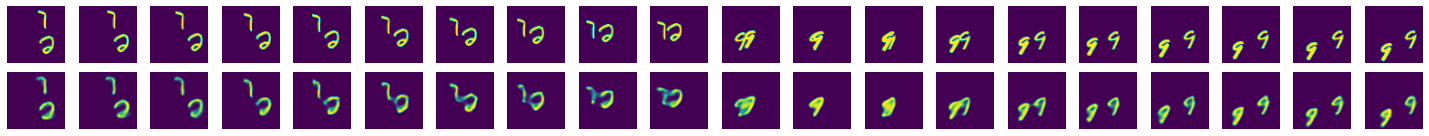

In [9]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


def plot_video_comparison(video,reconstructed_video):
    fig,ax = plt.subplots(2,20,figsize=(20,2))
    for i in range(20):
        ax[0,i].imshow(video[i,:,:])
        ax[0,i].axis('off')
    for i in range(20):
        ax[1,i].imshow(reconstructed_video[i,:,:])
        ax[1,i].axis('off')
    fig.tight_layout()

random_index = np.random.randint(1000)
sample = data[random_index]
sample = np.concatenate((data[random_index][:10],data[random_index+1][:10]))
sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor,generation_mode=False)
reconstructed_sample = y.cpu().detach().numpy().reshape((20,64,64))


plot_video_comparison(sample,reconstructed_sample)

In [20]:
var_posterior = np.exp(logvar.cpu().detach().numpy().reshape((20,latent_size)))
var_prior = np.exp(logvar_prior.cpu().detach().numpy().reshape((20,latent_size)))
latent_var = z.cpu().detach().numpy().reshape((20,latent_size))

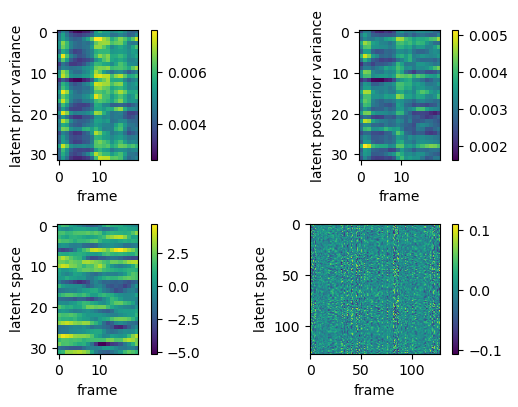

In [21]:
plt.figure()

plt.subplot(221)
plt.imshow(var_prior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prior variance')

plt.subplot(222)
plt.imshow(var_posterior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent posterior variance')

plt.subplot(223)
plt.imshow(latent_var.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.subplot(224)
plt.imshow(vrnn.rnn.weight_hh_l0.cpu().detach().numpy())
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.tight_layout()
plt.show()

In [70]:
var_posterior_list = []
var_prior_list = []
latent_var_list = []

for i in tqdm(range(100)):
    random_index = np.random.randint(10000)
    random_index1 = np.random.randint(10000)
    
    # compute the latent variance for one full video
    sample = np.concatenate((data[random_index]))
    sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
    y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor)
    var_posterior = np.exp(logvar.cpu().detach().numpy().reshape((20,latent_size)))
    var_prior = np.exp(logvar_prior.cpu().detach().numpy().reshape((20,latent_size)))
    latent_var = z.cpu().detach().numpy().reshape((20,latent_size))

    # concetanate two videos and compute the latent variance 
    sample_cut = np.concatenate((data[random_index][:10],data[random_index1][10:]))
    sample_tensor_cut = torch.reshape(torch.tensor(sample_cut).float(),(20,1,64,64)).float().to(device)
    y_cut, mean_cut, logvar_cut, mean_prior_cut, logvar_prior_cut, z_cut = vrnn.forward(sample_tensor_cut)
    var_posterior_cut = np.exp(logvar_cut.cpu().detach().numpy().reshape((20,latent_size)))
    var_prior_cut = np.exp(logvar_prior_cut.cpu().detach().numpy().reshape((20,latent_size)))
    latent_var_cut = z_cut.cpu().detach().numpy().reshape((20,latent_size))

    # remove the baseline
    var_posterior_list.append(var_posterior_cut - var_posterior)
    var_prior_list.append(var_prior_cut - var_prior)
    latent_var_list.append(latent_var_cut  - latent_var)

var_posterior_mean = np.mean(var_posterior_list,axis=0)
var_prior_mean = np.mean(var_prior_list,axis=0)
latent_var_mean = np.mean(latent_var_list,axis=0)

100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


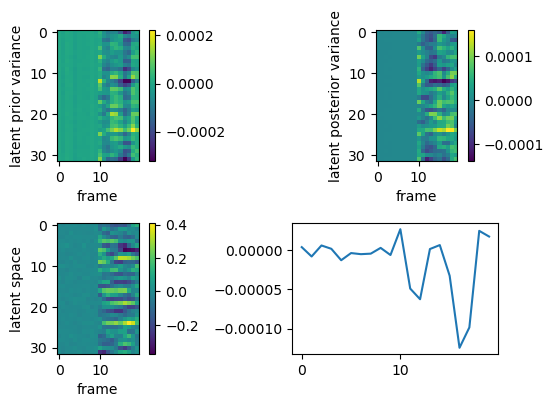

In [71]:
plt.figure()

plt.subplot(221)
plt.imshow(var_prior_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prior variance')

plt.subplot(222)
plt.imshow(var_posterior_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent posterior variance')

plt.subplot(223)
plt.imshow(latent_var_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.subplot(224)
plt.plot(np.mean(var_prior_mean,axis=1))

plt.tight_layout()
plt.show()

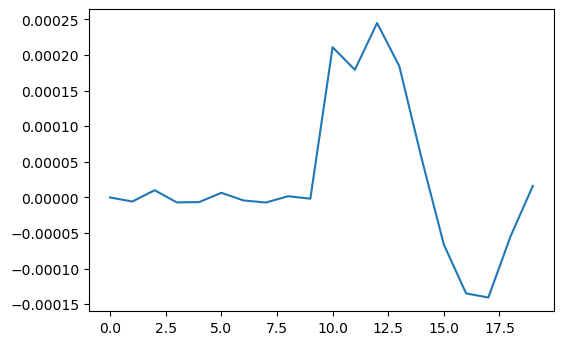